## Objective 
Q1 - Is vine reviews worth the investment - i.e., do vine reviewers share the same sentiment as the regular users ? 
Q2 - weed out bad vine reviewers.
Q2 - trends in books
Q3 - Recommender

In [853]:
import pandas as pd
import numpy as np
import random


import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,HashingVectorizer

from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans#, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn import metrics

from textblob import TextBlob
from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import InterclusterDistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Data Importing with Random Sampling

In [1375]:
filename = 'data/processed/books.csv'
n = sum(1 for line in open(filename))-1  # Calculate number of rows in file
s = n//100  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))  # n+1 to compensate for header 
df = pd.read_csv(filename, skiprows=skip)

In [1376]:
df.shape

(103190, 15)

In [24]:
def chunk_preprocessing(df, cols):
    df = df[cols]
    return df

In [1422]:
cols = ['review_id', 'review_date', 'review_body', 'product_parent', 'vine','verified_purchase', 'star_rating', 'customer_id', 'product_id']
df = chunk_preprocessing(df, cols).set_index('review_id')
df = df[df.review_date != ''] # eliminating the reviews without a date.
display(df.shape)
df.head()

(103190, 8)

,review_date,review_body,product_parent,vine,verified_purchase,star_rating,customer_id,product_id
review_id,,,,,,,,
R12EV35YZROIX,2015-08-31,Excellent--,402004849,N,Y,5,40676812,1938067126
R300KM7ZXCFVVL,2015-08-31,Very useful book a lot of procedures descripti...,344906230,N,Y,5,13130132,8578890396
RZIBB22JCNMW9,2015-08-31,I think Kevin's book is great. It's reality of...,133775648,N,N,5,42556923,1634170547
R2AF4CDXLTOWI,2015-08-31,Excellent reprint of an old esoteric work!,933328049,N,Y,5,52504922,116263118X
R3BZV1UE2JLK93,2015-08-31,My 2 year old son really loves this book. He s...,932960477,N,Y,5,49694645,078684972X


## EDA

In [1373]:
df.product_parent.nunique()

71230

In [320]:
def plot_dist (df):
    fig, ax = plt.subplots()
    plt.title('Distribution of ratings', fontsize=15)
    sns.countplot(df.star_rating)
    ax.set_ylabel('No. of Ratings(Millions)')
    plt.show()

In [321]:
def date_filter(df, start, end):
    mask = (df.timestamp > pd.to_datetime(start)) & (df.timestamp < pd.to_datetime(end))
    df = df[mask]
    return df

In [322]:
### Filtering_into_subgroups
def vine_reviewers_rating_filter(df, max_rate=5, min_rate=4, vine='Y'):
    df = df[df.vine == vine]
    df = df[(df.star_rating >= min_rate) & (df.star_rating <= max_rate)]
    return df

1. Are vine users a good representation of the regular user

A. compare 4-5star rated topics between regular user and vine user

B. compare 1-3 star rated topics between regular user and vine user

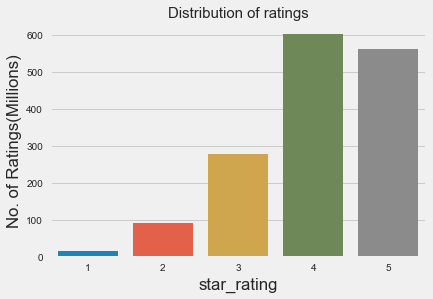

(1546, 15)

In [1377]:
all_vine_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='Y')
plot_dist(all_vine_user)
all_vine_user.shape

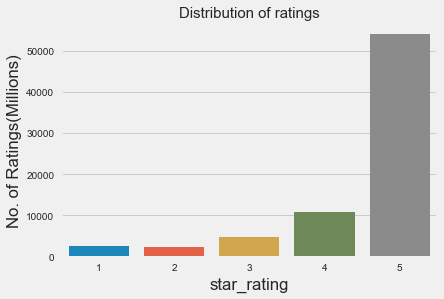

(74345,)

In [1380]:
all_regular_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='N')
all_regular_user = all_regular_user[all_regular_user.verified_purchase=='Y']
plot_dist(all_regular_user)
all_regular_user.star_rating.shape

In [1407]:
regular_user_low_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=4, min_rate=1, vine='N')
display(regular_user_low_rate.shape)
regular_user_low_rate.head()

(20385, 15)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
5,US,17138621,R2ZR04TCWVERTQ,0425226328,85012906,Murder in Mayberry: Greed Death and Mayhem in...,Books,2,1,1,N,Y,A Search for Answers,This is easy reading. The chapters plus book d...,2015-08-31
14,US,16803103,R3M9F59XPIKOB5,0393975150,707379043,Macroeconomics: Economic Growth Fluctuations ...,Books,4,0,0,N,Y,Excellent seller.,Good condition. Just as described.,2015-08-31
22,US,31369886,R19VJVOY9TGVCE,0072994355,298312837,Operations Management: Integrating Manufacturi...,Books,4,0,0,N,Y,useful for business majors or those interested...,Informative text useful for business majors o...,2015-08-31
27,US,33669122,R3T6Z3EESHQKY1,0805062998,516857219,The Number Devil: A Mathematical Adventure,Books,4,0,0,N,Y,Four Stars,Great buy !!!,2015-08-31
37,US,48557982,RHCAQOZC8LA1G,0945053371,162848364,Morse Code Teacher,Books,4,2,2,N,Y,WB6NOA is the way to go to learn the code.,Does anybody else really teach Morse code besi...,2015-08-31


In [1381]:
regular_user_high_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=5, min_rate=5, vine='N')
regular_user_high_rate.shape

(53960, 15)

In [1382]:
vine_user_low_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=4, min_rate=1, vine='Y')
vine_user_low_rate.shape

(985, 15)

In [1384]:
vine_user_high_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=5, min_rate=5, vine='Y')
vine_user_high_rate.shape

(561, 15)

In [1385]:
all_vine_user.customer_id.nunique()

997

2. weed out the reviewer with a taste that doesnt match with the majority
vine user group by user - for each user 
identify 4-5 star rated topics and 1-3 star rated topics.

In [352]:
vine_user_count = all_vine_user.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
vine_user_count = vine_user_count.sort_values('count', ascending=False)
vine_user_count = vine_user_count[vine_user_count['count']>=0]
#display(vine_user_count)
vine_user_id = list(vine_user_count['customer_id'].values)
display('Total number of vine reviewers', len(vine_user_id))
freq_vine_user_count = vine_user_count[vine_user_count['count']>=5]
display(freq_vine_user_count)
freq_vine_user_id = list(freq_vine_user_count['customer_id'].values)
display('Total number of frequent vine reviewers', len(freq_vine_user_id))


'Total number of vine reviewers'

610

,customer_id,count
310,46877221,38
473,51925793,18
78,21982343,11
217,39154578,9
384,50269104,9
515,52476646,9
593,53047657,9
563,52909137,9
221,39345823,9
497,52226443,8


'Total number of frequent vine reviewers'

40

In [351]:
# freq_vine_users_df = all_vine_user[all_vine_user.customer_id.isin(vine_user_id)]

# freq_vine_users_df_grouped = freq_vine_users_df.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
# freq_vine_users_df_grouped = freq_vine_users_df_grouped.sort_values('count', ascending=False)
# freq_vine_users_df_grouped = freq_vine_users_df_grouped[freq_vine_users_df_grouped['count']>=5]
# len(freq_vine_users_df_grouped)


40

In [359]:
freq_vine_user_hr = freq_vine_users_df[freq_vine_users_df.star_rating>3]
freq_vine_user_hr_grouped = pd.DataFrame(freq_vine_user_hr.groupby(\
                    ['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count())
freq_vine_user_hr_grouped = freq_vine_user_hr_grouped.drop(columns=['star_rating'])

vine_user_hr_grouped.head()

Empty DataFrame
Columns: []
Index: [(10170543, 5, I grew up quite near Lancaster  with a keen appreciation and respect for the Amish people and their culture. Many like me seem to have taken their admiration further  writing  about Amish life in popular fiction. Too much of it is inaccurate at best  even trashy at worst. Not so with this story. It shows the Amish life as much like our own  with parents worrying over children  children worrying over parents  and everyone wanting to find where they best fit  what God has in mind for them. This story sorts life out for a number of people  young and older. It's a pleasant read and a nice visit back home in Amish country.), (10370146, 4, Run You Down was my first exposure to author Julia Dahl.  This 279-page novel is written from the perspective of a mother  Aviva Kagan  housekeeper and her daughter  Rebekah Roberts  a New York Tribune reporter  who do not know each other.  This tale leans heavily on Jewish terms  culture and rebellion.<br /><br />I found the need to take notes on the key elements to understand the interrelationships between characters  follow the storyline early on and slowly unravel this unusual  yet well-written mystery.<br /><br />Sam Kagan  Aviva’s youngest brother was sexually and mentally abused; however  silence for the sake of religion and family honor trumped justice.  His best friend since childhood  Pessie Goldin loved him as he did her; however  he discovered a man  Ryan Hall that he loved is a different way.<br /><br />Ryan  like Sam hated the family circumstance that he was born in.  Ryan’s father and brother are intolerant haters—dangerous anti-Semitic racists—who would never tolerate his sexual orientation.<br /><br />Pessie  married Saul Katz  a retired NYPD officer turned private inspector.<br /><br />The crux of this mystery centers on unraveling the circumstances of Pessie’s death—a suicide or murder and why--and developing relationship cultural and family relationships.<br /><br />I struggled at the onset  but quickly became intrigued and immersed in this unusual yet believable tale and learned a lot about the Jewish culture in the process.<br /><br />I recommend this author and story to those that are patient  open minded and willing to piece together a carefully unfolding mystery.<br /><br />Enjoy!), (10370146, 5, Taylor Stevens is one of my favorite authors.  I am not only amazed at the obstacles that she overcame during her childhood  but am more in awe of her ability to unfold riveting tales with intriguing characters that hold my interest from beginning to end.<br /><br />The Mask is one such tale.  Protagonist Vanessa Michael Munroe is a flawed woman who easily transforms to a convincing male persona. Though she and Miles Bradford have a special bond and romantic relationship  they are able to separate their missions from their personal lives.<br /><br />In this case Miles  owner of Capstone Security Consulting accepts a security assignment in Japan where he is hired by an Executive of a major Bio-medical/technology company—ALTEQ-Bio to uncover a spy responsible for stealing trade secrets.<br /><br />Withholding information from Monroe  Miles comes under attack from ALTEQ Security  the spy and the mob and is convincingly framed for a murder of an innocent employee.<br /><br />Enter Monroe  a master assassin and Mile’s subcontractor  replacing him while he is under wraps.<br /><br />A variety of bad guys underestimate Monroe’s brilliance  skills and willingness to die fighting for her cause.<br /><br />This action packed mystery kept me on the edge of my seat rapidly flipping pages from beginning to end and completely satisfied with a well-written novel.<br /><br />I wholeheartedly recommend this book to those who enjoy a riveting  action packed well-written mystery with intriguing characters.<br /><br />Enjoy!), (10927980, 4, This story is fairly typical Amish fiction  with young adults reaching a time when they need to decide if they w

In [360]:
vine_user_lr = vine_users_df[vine_users_df.star_rating<4]
vine_user_lr_grouped = pd.DataFrame(vine_user_lr.groupby(['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count()).drop(columns=['star_rating'])


vine_user_lr_grouped.head()


Empty DataFrame
Columns: []
Index: [(33376665, 3, I loved the New England setting ( being a 10 generation New Englander myself). However the mom and daughter were not appealing or interesting. The plot never became believable for me and the pace was rarely compelling. I have read rave reviews of the author's other books [[ASIN:0061095052 A Woman's Place]]; [[ASIN:1416579567 Coast Road]]; [[ASIN:B00F1QX852 The Dream (Crosslyn Rise Trilogy Book 1)]]; [[ASIN:1451648413 Lake News]]; [[ASIN:B000OF06QE TOGETHER ALONE -OS]]so I will try another.), (33376665, 3, I was hoping for something fun to read and it started off great. We learn about her family and her home and her obsessions and fears. I visited the Dickinson home in October 2014 so this novel was a real treat.<br /><br />The family hires a new maid  an Irish immigrant  Ada.  Emily soaks up all things Ada. The story turns dark after this point for Ada. I think I would have enjoyed it more without the angst. Ada and Emily alternate telling the story  I have found that  for me  when this format is used I tend to not feel enmeshed in the characters and his was no exception - they just seem to come out a bit hollow.), (37337835, 2, I thought this book would never end  and when it did  I suspected that there would be a sequel. For me  that is not good news. I feel all there needed to be said about these Kardashian-types had already been said. Too many characters with nothing of importance to offer. Acquisition of pretty stuff -- lots of it  but I didn't care about the acquisition because I didn't care about the characters doing the acquiring. However  the cover is gorgeous!), (37337835, 3, At first I thought I could move through the reaction a lot of readers had to I Take You: A Novel. Be warned  this is not your average chick-lit. I wanted to like the character and forgive her anything because I knew this was a comedic novel that was designed to entertain. However  the more I read the less I found to like to the point that even as I sometimes chuckled I was also disturbed. In essence  I will say read it at your own risk  knowing that you may very well be disturbed by the heroine. Meh.), (37337835, 3, Eyes on You is a flashy quick read for people who like flashy quick TV mysteries. People are wearing great clothes and have great hair. Fake boobs enter the room before the woman does. Great shoes. Lots  really. The story is not one that will keep you up all night wondering about what will happen next  but it is a fun (and did I mention flashy) read. It's almost interchangeable with any mystery drama you've seen in the last several years. If this describes what you are looking for  you will most assuredly find it here. Not bad  but it is what it is.)]

In [367]:
most_reviewed_vine_cus = freq_vine_users_df[freq_vine_users_df.customer_id==46877221]
len(most_reviewed_vine_cus)
most_reviewed_vine_cus.iloc[0,:]

review_date                                                 2015-06-18
review_body          This has humor and it has a dark side.  The se...
vine                                                                 Y
verified_purchase                                                    N
star_rating                                                          4
customer_id                                                   46877221
product_id                                                  0062364839
Name: R1ETM5M793D1SJ, dtype: object

## Text Preprocessing

1. change product_title to review body
2. date separations monthwise

Plan
3. separate vine vs non-vine topics
4. text preprocessing - with spacy / nltk.

In [1409]:
regular_users_lr_corpus = pd.DataFrame(regular_user_low_rate, columns=['review_body', 'star_rating'])
regular_users_lr_corpus = regular_users_lr_corpus.dropna().reset_index(drop=True)
display(len(regular_users_lr_corpus))
regular_users_lr_corpus.head()

20384

,review_body,star_rating
0,This is easy reading. The chapters plus book d...,2
1,Good condition. Just as described.,4
2,Informative text useful for business majors o...,4
3,Great buy !!!,4
4,Does anybody else really teach Morse code besi...,4


In [1410]:
regular_users_hr_corpus = pd.DataFrame(regular_user_high_rate, columns=['review_body', 'star_rating'])
regular_users_hr_corpus = regular_users_hr_corpus.dropna().reset_index(drop=True)
display(len(regular_users_hr_corpus))
regular_users_hr_corpus.head()

53957

,review_body,star_rating
0,Excellent--,5
1,Very useful book a lot of procedures descripti...,5
2,Excellent reprint of an old esoteric work!,5
3,My 2 year old son really loves this book. He s...,5
4,Absolutely chilling. I clicked graphic violen...,5


In [1411]:
vine_users_lr_corpus = pd.DataFrame(vine_user_low_rate, columns=['review_body', 'star_rating'])
vine_users_lr_corpus = vine_users_lr_corpus.dropna().reset_index(drop=True)
display(len(vine_users_lr_corpus))
vine_users_lr_corpus.head()

985

,review_body,star_rating
0,You may be familiar with Lonely Planet from th...,4
1,Wow-what a slew of crazy story's! And you thou...,4
2,Eric Lindstrom's NOT IF I SEE YOU FIRST is a Y...,4
3,After enjoying the author's wonderful first bo...,3
4,I was familiar with the author and his father ...,4


In [1412]:
vine_users_hr_corpus = pd.DataFrame(vine_user_high_rate, columns=['review_body', 'star_rating'])
vine_users_hr_corpus = vine_users_hr_corpus.dropna().reset_index(drop=True)
display(len(vine_users_hr_corpus))
vine_users_hr_corpus.head()

561

,review_body,star_rating
0,With all the focus on common core curriculum ...,5
1,This is another wonderful book from author WH ...,5
2,I have to write this review right this minute....,5
3,This structural engineering manual is as thoro...,5
4,This book was a very pleasant surprise for me....,5


### Test Cleaning

In [1404]:
import regex as re
def text_cleaning(corpus):
    return re.sub(r'[^\w]\n', ' ', corpus)

In [1413]:
for i in range(len(vine_users_hr_corpus)):
    vine_users_hr_corpus.loc[i,'review_body'] = text_cleaning(vine_users_hr_corpus.loc[i,'review_body'])

In [1414]:
for i in range(len(vine_users_lr_corpus)):
    vine_users_lr_corpus.loc[i,'review_body'] = text_cleaning(vine_users_lr_corpus.loc[i,'review_body'])

In [1415]:
for i in range(len(regular_users_hr_corpus)):
    regular_users_hr_corpus.loc[i,'review_body'] = text_cleaning(regular_users_hr_corpus.loc[i,'review_body'])

In [1417]:
for i in range(len(regular_users_lr_corpus)):
    regular_users_lr_corpus.loc[i,'review_body'] = text_cleaning(regular_users_lr_corpus.loc[i,'review_body'])

### Adding Stop Words

In [1418]:
stop_words = stopwords.words('english')

In [1419]:
sw_list1 = ['fascinating', 'enthralling', 'engrossing', 'nice', 
                        'people','youre', 'wa', 'book', 'good', 'buy', 'bought', 
                        'ok', 'better', 'best', 'help', 'little', 'br',
                        'br br', 'author', 'book br', 'ha', 'expected', 'wasn',
                        'okay', 'quite', 'story', 'really', 'didn', 'little',
                        'information', 'disappointed', 'read', 'interesting', 
                        'read book', 'hard', 'easy', 'page', 'cover', 'small',
                        'missing', 'quality', 'helpful', 'feel', 'description', 
                        'great', 'good', 'better', 'best','enjoy', 'boring', 
                        'poorly', 'he', 'awesome', 'bad', 'actually', 'words', 
                        'pages', 'thought', 'would', 'thing', 'well', 'written', 'read',
                        'reading', 'thinking', 'get', 'could', 'many', 'lot', 'amazing',
                        'also', 'books', 'perfect', 'way', 'make', 'us', 'highly', 'copy', 
                        'full', 'must', 'anyone', 'like', 'long', 'high', 'fast', 'wanted',
                        'text', 'came', 'use', 'liked', 'wonderful', 'excellent', 'wait', 
                       'beautiful', 'see', 'thank', 'thanks', 'thanked', 'needed', 'got',
                       'every']
stop_words.extend(sw_list1)

#### POS - Adj / Adv removal

In [1420]:
from spacy import displacy
from itertools import chain
import itertools

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def add_stop_words(doc):
    new_stop_words_ = []
    for t in doc:
            if (t.pos_ == 'ADJ') or (t.pos_ == 'ADV'):
                new_stop_words_.append(t)
    return list(set(new_stop_words_))

sw_list2 = []
for doc in nlp.pipe(regular_users_corpus.review_body):
    sw_list2 = itertools.chain(sw_list2, add_stop_words(doc))

In [1421]:
for i in sw_list2:
    stop_words.append(i)

stop_words = list(set(stop_words))
len(stop_words)

571815

#### bigrams

In [1423]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [1424]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [1425]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[words], min_count = tri_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod, trigram_mod

In [1426]:
for doc in nlp.pipe(regular_users_corpus.review_body):
    words = list(sent_to_words(doc))

KeyboardInterrupt: 

In [ ]:
words

In [1070]:
bigram_tr, trigram_tr = bigrams(words)

In [1071]:
bigram_tr

In [1431]:
cv = CountVectorizer(stop_words=stop_words, min_df=0.01, max_df=0.1)
doc_word = cv.fit_transform(regular_users_corpus.review_body)
cv_corpus = pd.DataFrame(doc_word.toarray(), columns=cv.get_feature_names(), index=regular_users_corpus.index)
cv_corpus.head()


,able,absolutely,age,ago,almost,along,already,although,always,amazon,...,works,world,worth,write,writer,writing,year,years,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Testing Spacy
#### Spacy to get parts of speech (pos_) and dependency (dep_)


#### Spacy nlp.pipe to process documents

In [1073]:
# %%time
# from spacy import displacy
# nlp = spacy.load('en_core_web_sm')

# def text_preprocess(text):
#     doc = nlp(text)
#     for t in doc:
#         if t.lower_ in ['awesome', 'super', 'excellent']:
#             if t.pos_ != 'NOUN' :
#                 if t.dep_ != 'amod':
#                     return True
#     return False

# #generator
# new_corpora = (i for i in corpus if text_preprocess(i))
# [next(new_corpora) for i in range (3)]

In [1074]:
# sentence = "The book was super interesting."
# displacy.render(nlp(sentence))
# #spacy.explain("acomp")

### Lemmatize and Stemming

In [1432]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
snowball_stem = SnowballStemmer('english')
lancaster_stem = LancasterStemmer('english')

from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [1433]:
def snowball(text):
    return ' '.join([snowball_stem.stem(word) for word in text.split(' ')])

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])

Initial trial on 50% of data showed that lemmatization worked best, compared to stemming. So Lemmatization was used for all subsequent tests

In [1436]:
#regular_users_corpus['snowball'] = regular_users_corpus.review_body.apply(snowball)

In [1437]:
regular_users_hr_corpus['lemmatized'] = regular_users_hr_corpus.review_body.apply(lemmatize)

In [1438]:
regular_users_lr_corpus['lemmatized'] = regular_users_lr_corpus.review_body.apply(lemmatize)

In [1439]:
vine_users_hr_corpus['lemmatized'] = vine_users_hr_corpus.review_body.apply(lemmatize)

In [1440]:
regular_users_lr_corpus['lemmatized'] = regular_users_lr_corpus.review_body.apply(lemmatize)

### Countvectorizer and TFIDF

In [ ]:
tfidf_stemmed = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_tfidf_stemmed = tfidf_stemmed.fit_transform(regular_users_corpus.snowball)

tfidf_stemmed_dtm = pd.DataFrame(X_tfidf_stemmed.toarray(), columns=tfidf_stemmed.get_feature_names(), index=regular_users_corpus.lemmatized.index)
tfidf_stemmed_dtm.head()

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_tfidf = tfidf.fit_transform(regular_users_corpus.lemmatized)

tfidf_dtm = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names(), index=regular_users_corpus.lemmatized.index)
tfidf_dtm.shape

In [1444]:
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_cv = cv.fit_transform(regular_users_corpus.lemmatized)

cv_dtm = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names(), index=regular_users_corpus.lemmatized.index)
cv_dtm.head()

AttributeError: 'DataFrame' object has no attribute 'lemmatized'

## Clustering

In [1346]:
def find_optimal_clusters(data,min_k=2, max_k=16, delta_k=2):
    iters = range(min_k, max_k+1,delta_k)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, random_state=87,batch_size=1500,n_init=8).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('no. clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('inertia')
    ax.set_title('inertia by no. clusters')

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters


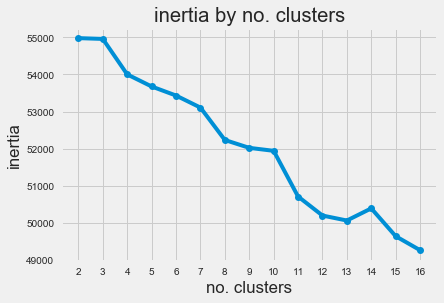

In [1350]:
find_optimal_clusters(X_tfidf, min_k=2, max_k=16, delta_k=1)

In [1369]:
nc=5
km = KMeans(n_clusters=nc, init='k-means++', max_iter=100, n_init=5, random_state=5, verbose=False)
km.fit(X_tfidf)
print("Silhouette Coefficient: %0.3f"
  % metrics.silhouette_score(X_tfidf, km.labels_, sample_size=1000))
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nc):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :12]:
        print(' %s\n' % terms[ind], end='')
print()

Silhouette Coefficient: 0.135
Cluster 0:
 loved
 gift
 daughter
 son
 friend
 much
 kid
 series
 absolutely
 child
 put
 character
Cluster 1:
 much
 life
 series
 recommend
 condition
 new
 gift
 enjoyed
 work
 fun
 know
 first
Cluster 2:
 different
 cute
 idea
 fun
 life
 much
 even
 recommend
 give
 think
 look
 new
Cluster 3:
 time
 first
 life
 arrived
 much
 character
 know
 recommend
 take
 even
 back
 find
Cluster 4:
 old
 year
 year old
 daughter
 son
 loved
 fun
 new
 series
 first
 day
 much



/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x20aebd510>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

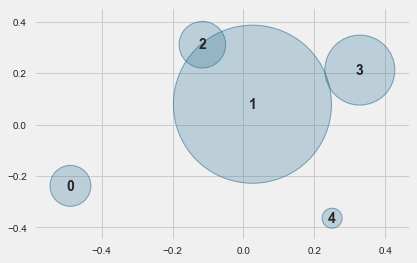

In [1370]:
icvis = InterclusterDistance(km)
icvis.fit(doc_word,km.labels_)

In [1365]:
nc=6
km = KMeans(n_clusters=nc, init='k-means++', max_iter=100, n_init=5,random_state=5, verbose=False)
km.fit(X_tfidf)
print("Silhouette Coefficient: %0.3f"
  % metrics.silhouette_score(X_tfidf, km.labels_, sample_size=1000))
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nc):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :12]:
        print(' %s\n' % terms[ind], end='')
print()

Silhouette Coefficient: 0.139
Cluster 0:
 loved
 gift
 daughter
 son
 much
 friend
 kid
 series
 absolutely
 time
 put
 first
Cluster 1:
 life
 time
 character
 much
 world
 know
 recommend
 family
 real
 give
 think
 change
Cluster 2:
 cute
 fun
 kid
 son
 child
 daughter
 gift
 picture
 loved
 old
 favorite
 still
Cluster 3:
 work
 time
 much
 recommend
 first
 even
 need
 new
 find
 know
 want
 life
Cluster 4:
 old
 year
 year old
 daughter
 son
 time
 loved
 fun
 new
 series
 day
 kid
Cluster 5:
 time
 much
 series
 recommend
 condition
 new
 gift
 fun
 enjoyed
 know
 first
 informative



/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1742d6c10>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

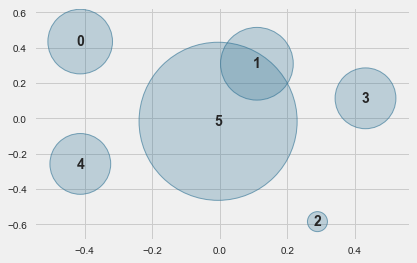

In [1366]:
icvis = InterclusterDistance(km)
icvis.fit(doc_word,km.labels_)

In [1367]:
nc=7
km = KMeans(n_clusters=nc, init='k-means++', max_iter=100, n_init=5, random_state=5, verbose=False)
km.fit(X_tfidf)
print("Silhouette Coefficient: %0.3f"
  % metrics.silhouette_score(X_tfidf, km.labels_, sample_size=1000))
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nc):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :12]:
        print(' %s\n' % terms[ind], end='')
print()

Silhouette Coefficient: 0.152
Cluster 0:
 loved
 gift
 daughter
 much
 friend
 series
 kid
 absolutely
 time
 put
 character
 first
Cluster 1:
 life
 time
 character
 much
 world
 know
 recommend
 family
 real
 think
 give
 change
Cluster 2:
 cute
 fun
 kid
 son
 child
 daughter
 gift
 picture
 loved
 old
 favorite
 still
Cluster 3:
 work
 time
 much
 recommend
 first
 even
 need
 new
 find
 know
 want
 life
Cluster 4:
 old
 year
 year old
 daughter
 son
 time
 loved
 fun
 new
 series
 day
 kid
Cluster 5:
 time
 much
 series
 recommend
 condition
 new
 gift
 fun
 enjoyed
 know
 first
 informative
Cluster 6:
 son
 loved
 gift
 series
 favorite
 kid
 time
 enjoyed
 school
 child
 much
 old



/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x2050bbe50>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

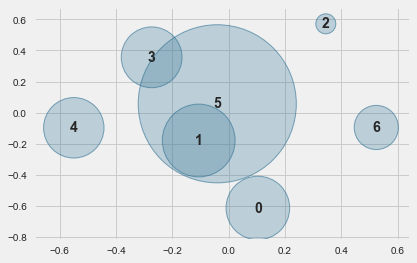

In [1368]:
icvis = InterclusterDistance(km)
icvis.fit(doc_word,km.labels_)

In [1441]:
nc=8
km = KMeans(n_clusters=nc, init='k-means++', max_iter=100, n_init=5,random_state=5, verbose=False)
km.fit(X_tfidf)
print("Silhouette Coefficient: %0.3f"
  % metrics.silhouette_score(X_tfidf, km.labels_, sample_size=1000))
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(nc):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :12]:
        print(' %s\n' % terms[ind], end='')
print()

Silhouette Coefficient: 0.124
Cluster 0:
 fun
 much
 kid
 color
 series
 old
 cute
 year
 time
 gift
 child
 character
Cluster 1:
 time
 first
 life
 year
 character
 know
 back
 even
 take
 recommend
 find
 favorite
Cluster 2:
 work
 reference
 life
 time
 recommend
 even
 know
 first
 need
 new
 want
 much
Cluster 3:
 loved
 gift
 daughter
 son
 series
 old
 kid
 absolutely
 friend
 year
 year old
 character
Cluster 4:
 arrived
 condition
 time
 described
 purchase
 product
 new
 looking
 exactly
 gift
 price
 happy
Cluster 5:
 price
 worth
 product
 condition
 right
 much
 purchase
 new
 school
 time
 described
 happy
Cluster 6:
 much
 enjoyed
 know
 life
 pretty
 first
 recommend
 new
 find
 think
 character
 found
Cluster 7:
 series
 life
 recommend
 gift
 new
 condition
 enjoyed
 year
 know
 informative
 old
 first



/Users/samypalaniappan/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x166858b90>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

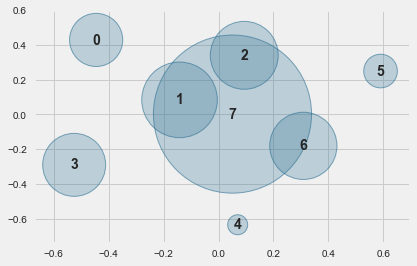

In [1364]:
icvis = InterclusterDistance(km)
icvis.fit(doc_word,km.labels_)

## Topic Modeling

In [1319]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF

In [1320]:
def nmf_test(X, vec, dim):
    
    nmf = NMF(dim, random_state=5)
    nmf_topic = nmf.fit_transform(X)
    nmf_word = pd.DataFrame(nmf.components_.round(5),
                           index=np.arange(1,dim+1),
                           columns=vec.get_feature_names())
    topics = nmf_word.transpose()
    for i, categories in enumerate(topics.columns):
        keywords = topics.loc[:,categories].sort_values(ascending=False).head(5)
        print(f'Topic {i}: {keywords.index.values}\n')
        
    return nmf, nmf_topic

In [1442]:
nmf_5, topics_5 = nmf_test(X_tfidf, tfidf, 5)
len(topics)

Topic 0: ['much' 'life' 'recommend' 'year' 'know']

Topic 1: ['loved' 'gift' 'daughter' 'son' 'friend']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'next' 'favorite']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']



77844

In [1443]:
nmf_5, topics_5 = nmf_test(X_cv, cv, 5)
len(topics)

ValueError: Shape of passed values is (5, 188), indices imply (5, 270)

In [1330]:
nmf_6, topics_6 = nmf_test(X_tfidf, tfidf, 6)
len(topics)

Topic 0: ['much' 'life' 'recommend' 'year' 'know']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'absolutely']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'enjoyed' 'character' 'next' 'favorite']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']

Topic 5: ['gift' 'friend' 'gave' 'purchased' 'enjoyed']



77844

In [1331]:
nmf_7, topics_7 = nmf_test(X_tfidf, tfidf, 7)
len(topics)

Topic 0: ['life' 'recommend' 'year' 'know' 'work']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'absolutely']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'next' 'favorite']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']

Topic 5: ['gift' 'friend' 'gave' 'purchased' 'daughter']

Topic 6: ['much' 'enjoyed' 'fun' 'pretty' 'happy']



77844

In [1332]:
nmf_8, topics_8 = nmf_test(X_tfidf, tfidf, 8)
len(topics)

Topic 0: ['life' 'recommend' 'know' 'work' 'new']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'absolutely']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'favorite' 'next']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']

Topic 5: ['gift' 'friend' 'gave' 'purchased' 'enjoyed']

Topic 6: ['much' 'enjoyed' 'fun' 'pretty' 'happy']

Topic 7: ['old' 'year' 'year old' 'fun' 'daughter']



77844

In [1333]:
nmf_9, topics_9 = nmf_test(X_tfidf, tfidf, 9)
len(topics)

Topic 0: ['life' 'recommend' 'know' 'work' 'new']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'absolutely']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'favorite' 'next']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']

Topic 5: ['gift' 'friend' 'gave' 'purchased' 'daughter']

Topic 6: ['much' 'enjoyed' 'pretty' 'happy' 'say']

Topic 7: ['old' 'year' 'year old' 'son' 'daughter']

Topic 8: ['fun' 'kid' 'cute' 'informative' 'color']



77844

In [1326]:
nmf, topics = nmf_test(X_tfidf, tfidf, 10)
len(topics)

Topic 0: ['life' 'know' 'work' 'new' 'first']

Topic 1: ['loved' 'daughter' 'son' 'kid' 'absolutely']

Topic 2: ['condition' 'arrived' 'price' 'described' 'new']

Topic 3: ['series' 'character' 'enjoyed' 'favorite' 'next']

Topic 4: ['time' 'arrived' 'described' 'first' 'favorite']

Topic 5: ['gift' 'friend' 'gave' 'purchased' 'enjoyed']

Topic 6: ['much' 'enjoyed' 'pretty' 'happy' 'say']

Topic 7: ['old' 'year' 'year old' 'son' 'daughter']

Topic 8: ['fun' 'kid' 'cute' 'color' 'child']

Topic 9: ['recommend' 'informative' 'product' 'everyone' 'definitely']



77844

In [1327]:
# Appears that 8 topics is ideal. for a TF-IDF max_df of 0.1

In [1334]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_tfidf)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5), columns = tfidf.get_feature_names())
display_topics(nmf, tfidf.get_feature_names(), 10)


Topic  0
life, recommend, know, work, new, want, first, even, character, need

Topic  1
loved, daughter, son, kid, absolutely, friend, put, next, child, character

Topic  2
condition, arrived, price, described, new, product, used, happy, exactly, purchase

Topic  3
series, character, enjoyed, favorite, next, whole, another, first, son, fan

Topic  4
time, arrived, described, first, favorite, worth, several, back, take, second

Topic  5
gift, friend, gave, purchased, enjoyed, daughter, given, give, son, someone

Topic  6
much, enjoyed, fun, pretty, happy, say, bit, found, detail, made

Topic  7
old, year, year old, fun, daughter, son, cute, kid, child, school


In [1336]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_cv)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5),columns = cv.get_feature_names())
display_topics(nmf, cv.get_feature_names(), 10)


Topic  0
even, know, want, think, work, need, new, give, find, world

Topic  1
question, new, word, guide, student, recommend, review, set, different, problem

Topic  2
life, god, doe, end, word, never, bible, away, come, day

Topic  3
time, work, day, woman, back, kid, felt, family, take, experience

Topic  4
character, novel, series, end, even, loved, enjoyed, reader, writing, always

Topic  5
year, old, year old, child, daughter, family, day, school, son, back

Topic  6
first, series, two, chapter, second, loved, person, another, recommend, next

Topic  7
much, enjoyed, still, pretty, loved, bit, back, never, found, end


In [1209]:
nmf = NMF(8, random_state=5)
nmf_topic = nmf.fit_transform(X_tfidf_stemmed)
nmf_topics_words = pd.DataFrame(nmf.components_.round(5), columns = tfidf_stemmed.get_feature_names())
display_topics(nmf, tfidf_stemmed.get_feature_names(), 10)


Topic  0
time, much, recommend, look, work, want, mani, life, year, know

Topic  1
excel, product, condit, recommend, refer, price, arriv, studi, guid, wonder

Topic  2
thank, much, wonder, arriv, happi, product, price, condit, quick, receiv

Topic  3
use, easi, class, studi, refer, recip, learn, guid, practic, school

Topic  4
inform, easi, provid, understand, detail, present, found, pictur, need, guid

Topic  5
interest, anyon, histori, recommend, detail, charact, subject, found, research, insight

Topic  6
realli, fun, think, son, cute, series, charact, seri, daughter, made

Topic  7
stori, wonder, charact, beauti, line, life, tell, short, end, novel


In [1259]:
nmf_topic

array([[2.89194470e-02, 1.06267879e-03, 2.37306279e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.68703764e-03, 6.52002077e-06, 0.00000000e+00, ...,
        0.00000000e+00, 8.93979324e-02, 1.99187788e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.67161329e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.79494043e-03, 1.93249759e-05],
       [0.00000000e+00, 1.68528699e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [1227]:
topic_map = {
    0: 'Educational - Study Material',
    1: 'Self-Help',
    2: 'Children Books',
    3: 'Series Books',
    4: 'Illustrative Books',
    5: 'Book Condition',
    6: 'for Gifting',
    7: 'Delivery time'
}

### LSA

In [1210]:
lsa = TruncatedSVD(8, random_state=5)
lsa_topics = lsa.fit_transform(X_cv)
dtm_lsa = display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
time, life, much, even, first

Topic  1
question, new, guide, word, student

Topic  2
life, god, doe, end, word

Topic  3
character, series, novel, life, end

Topic  4
time, character, life, novel, question

Topic  5
year, life, old, year old, child

Topic  6
year, god, series, old, character

Topic  7
world, character, history, new, work


In [1211]:
lsa = TruncatedSVD(8, random_state=5)
lsa_topics = lsa.fit_transform(X_tfidf)
dtm_lsa = display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
excellent, time, condition, loved, life

Topic  1
time, loved, much, life, series

Topic  2
loved, gift, daughter, son, excellent

Topic  3
series, enjoyed, character, next, fun

Topic  4
wonderful, series, gift, thanks, condition

Topic  5
condition, series, time, thank, arrived

Topic  6
gift, old, fun, year, condition

Topic  7
time, gift, series, wonderful, beautiful


In [1271]:
regular_users_corpus['NMF_topic'] = topics_8.argmax(axis=1)
regular_users_corpus['NMF_topic_name'] = regular_users_corpus.NMF_topic.map(topic_map)

In [1280]:
regular_users_corpus.head()

,review_body,star_rating,snowball,lemmatized,topic,topic_name,NMF_topic,NMF_topic_name
review_id,,,,,,,,
R2KYFH2IXTO2LS,Beginners in JS will likely struggle with some...,3,beginn in js will like struggl with some of th...,Beginners in JS will likely struggle with some...,2,Meeting Expectation,1,Self-Help
R31IKMCDVV8F80,great book,5,great book,great book,0,Writing Quality,0,Educational - Study Material
RTJ97FQ2M36PH,Great book for helping children really learn w...,5,great book for help children realli learn what...,Great book for helping child really learn what...,2,Meeting Expectation,1,Self-Help
RCGXSB3JUGTHQ,This book is wonderful. This author has spent ...,5,this book is wonderful. this author has spent ...,This book is wonderful. This author ha spent h...,2,Meeting Expectation,1,Self-Help
R1KS2IC6WOE71Y,This novel strikes so close to home......I hav...,5,this novel strike so close to home......i have...,This novel strike so close to home......I have...,2,Meeting Expectation,1,Self-Help


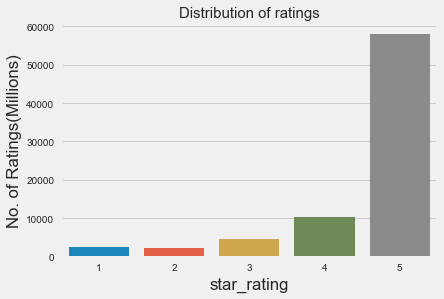

In [1273]:
plot_dist(regular_users_corpus)


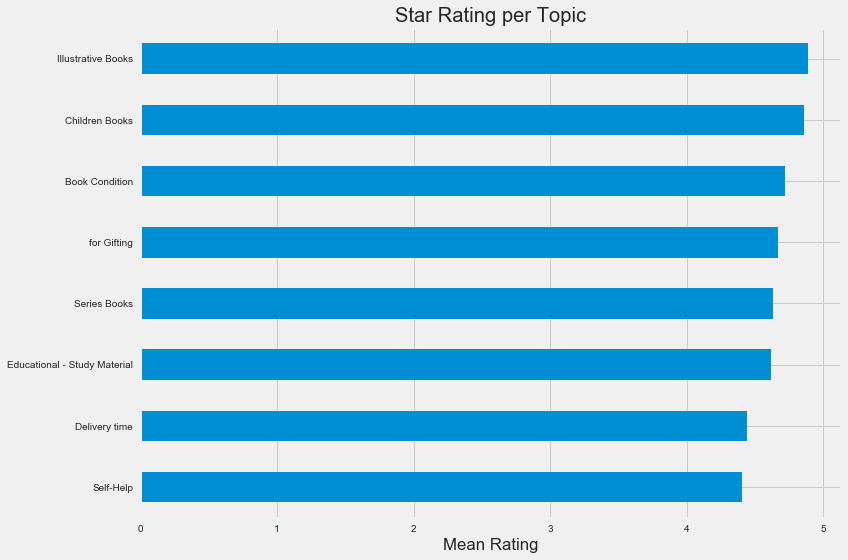

In [1274]:
plt.figure(figsize=(12, 8))
topic_stars_grouped = regular_users_corpus.groupby('NMF_topic_name').star_rating.mean().sort_values()
# corpus.groupby('topic_name').claps.mean().sort_values().plot(kind='barh')
topic_stars_grouped.plot(kind='barh')
plt.xlabel('Mean Rating')
plt.ylabel('')
plt.title('Star Rating per Topic')
plt.tight_layout()
# plt.savefig('median_claps_topic.svg');

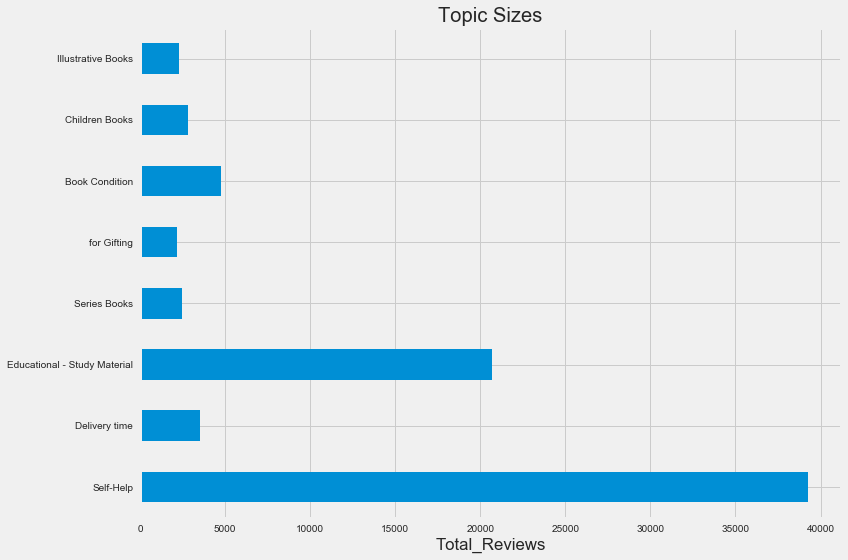

In [1275]:
plt.figure(figsize=(12, 8))
regular_users_corpus.groupby('NMF_topic_name').topic.count()[topic_stars_grouped.index].plot(kind='barh')
plt.xlabel('Total_Reviews')
plt.ylabel('')
plt.title('Topic Sizes')
plt.tight_layout()
# plt.savefig('topic_sizes.svg');

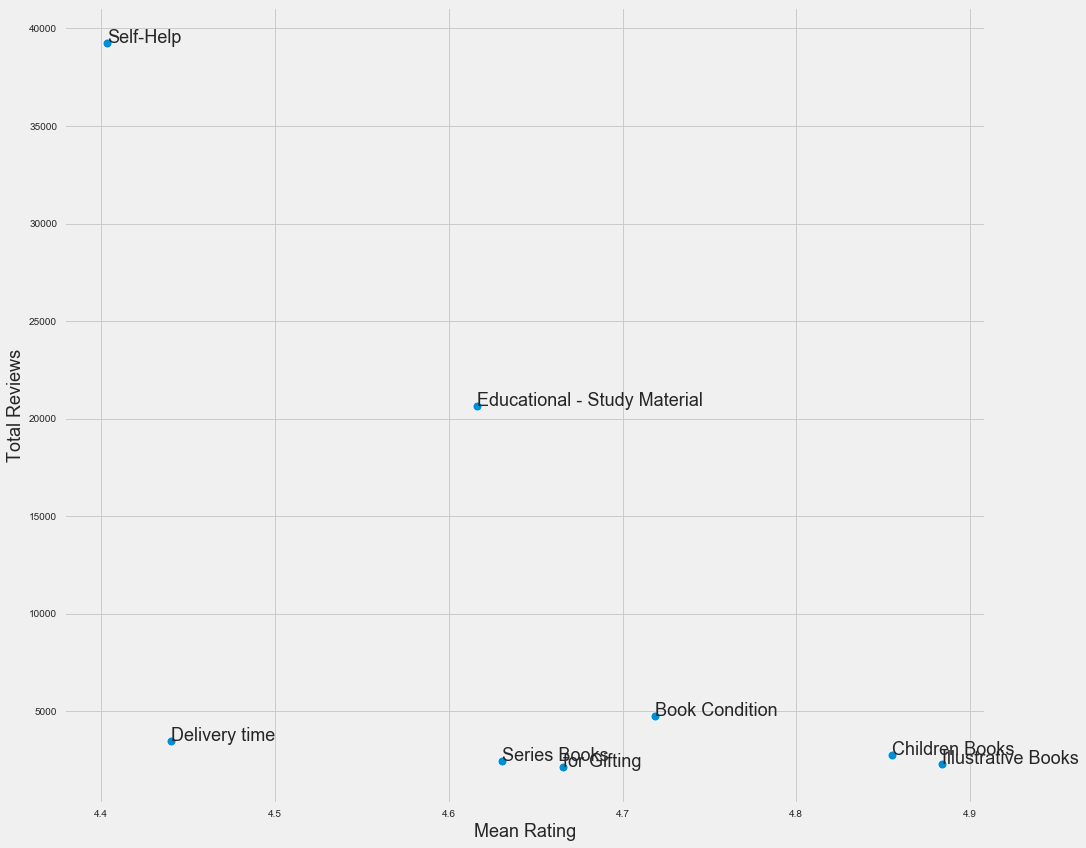

In [1290]:
plt.figure(figsize=(14,12))
data = regular_users_corpus.groupby('NMF_topic_name').agg({'star_rating':'mean', 'NMF_topic':'count'}).sort_index()
data['name'] = data.index
sns.scatterplot(x='star_rating', y='NMF_topic', data=data, s=80)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), size=18)

label_point(data.star_rating, data.NMF_topic, data.name, plt.gca())

plt.xlabel('Mean Rating', size=18)
plt.ylabel('Total Reviews', size=18)
plt.tight_layout()
# plt.savefig('article_clap_scatter.svg');




## Visualization

In [1263]:
nmf_sc = StandardScaler().fit_transform(topics_8)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=5)
nmf_pca = pca.fit_transform(nmf_sc)

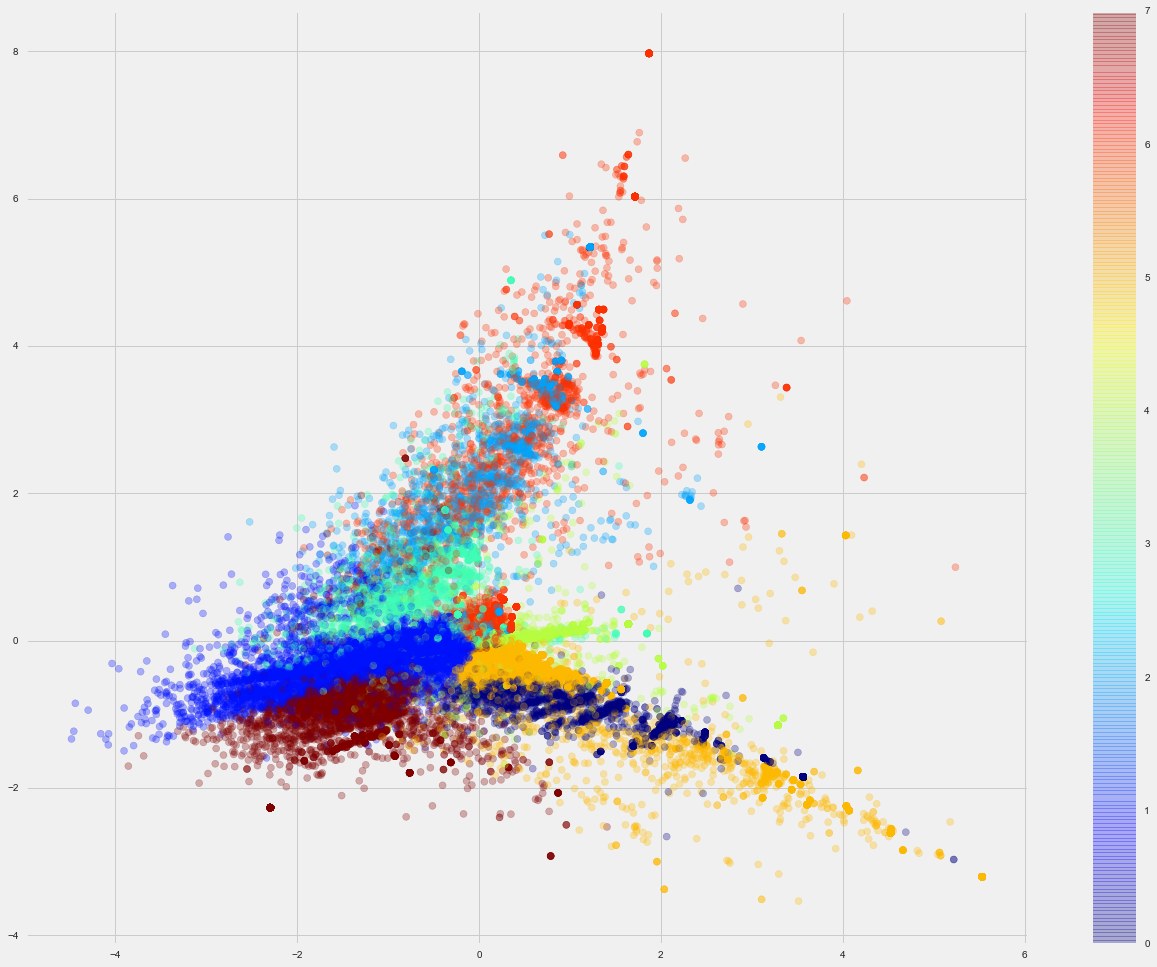

In [1264]:
plt.figure(figsize=(20,16))
plt.scatter(nmf_pca[:,0], nmf_pca[:,1], c=nmf_sc.argmax(axis=1), cmap='jet', alpha=0.3)
plt.colorbar();

In [1291]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, verbose=0)
data = model.fit_transform(nmf_sc)

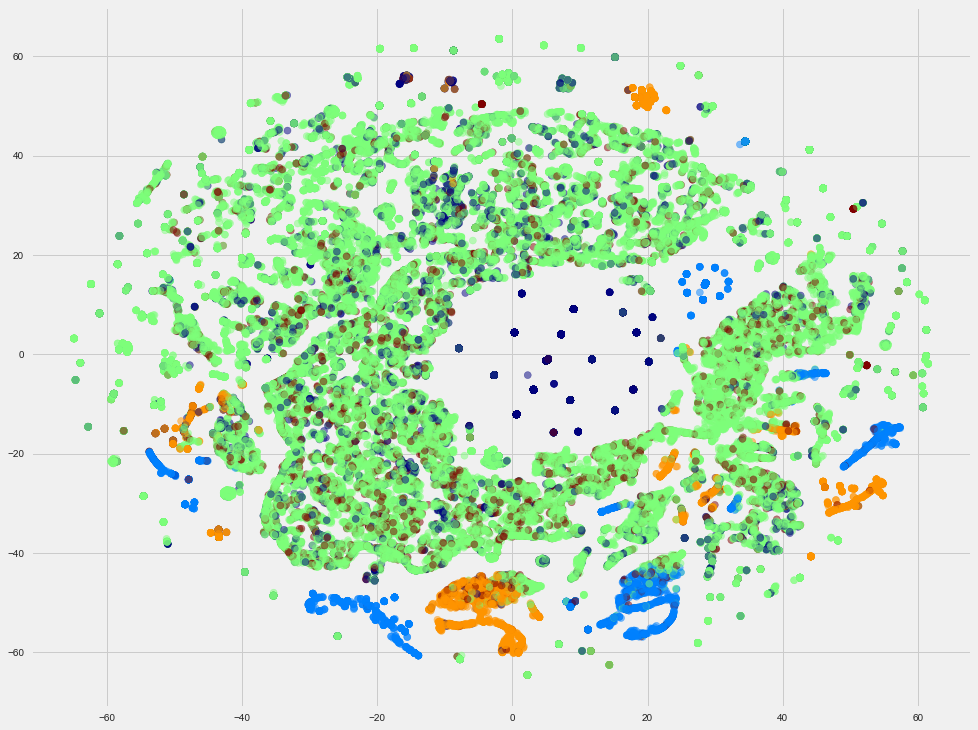

In [1293]:
plt.figure(figsize=(15,12))
plt.scatter(data[:,0], data[:,1], c=regular_users_corpus.topic,cmap='jet', alpha=.5);

## LDA

In [1337]:
from gensim import corpora, models, similarities, matutils


In [1338]:
doc_word_cv = cv.transform(regular_users_corpus.review_body).transpose()
doc_word_tfidf = tfidf.transform(regular_users_corpus.review_body).transpose()

In [1339]:
corpus_cv = matutils.Sparse2Corpus(doc_word_cv)
corpus_tfidf = matutils.Sparse2Corpus(doc_word_tfidf)

In [1340]:
id2word_cv = dict((v, k) for k, v in cv.vocabulary_.items())
id2word_tfidf = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [1341]:
len(id2word_cv)

188

In [1342]:
lda_cv = models.LdaModel(corpus=corpus_cv, num_topics=8, id2word=id2word, passes=5, random_state=5)
lda_tfidf = models.LdaModel(corpus=corpus_tfidf, num_topics=8, id2word=id2word, passes=5, random_state=5)

In [1343]:
lda_cv.print_topics()

[(0,
  '0.154*"purchased" + 0.081*"kind" + 0.066*"color" + 0.052*"learn" + 0.052*"wanted" + 0.051*"hope" + 0.048*"example" + 0.042*"arrived" + 0.040*"kid" + 0.037*"chapter"'),
 (1,
  '0.041*"study" + 0.037*"might" + 0.032*"kind" + 0.029*"two" + 0.027*"understand" + 0.025*"may" + 0.022*"enough" + 0.020*"making" + 0.017*"gift" + 0.017*"start"'),
 (2,
  '0.135*"done" + 0.121*"friend" + 0.066*"especially" + 0.062*"point" + 0.060*"first" + 0.058*"forward" + 0.052*"fun" + 0.049*"condition" + 0.040*"said" + 0.040*"making"'),
 (3,
  '0.090*"review" + 0.076*"far" + 0.062*"useful" + 0.049*"mind" + 0.041*"much" + 0.040*"another" + 0.038*"change" + 0.036*"text" + 0.034*"last" + 0.033*"interested"'),
 (4,
  '0.071*"beautiful" + 0.066*"thank" + 0.056*"someone" + 0.055*"pretty" + 0.048*"time" + 0.046*"question" + 0.045*"put" + 0.045*"came" + 0.043*"child" + 0.042*"back"'),
 (5,
  '0.062*"simple" + 0.050*"thanks" + 0.043*"enough" + 0.042*"still" + 0.040*"life" + 0.038*"big" + 0.033*"recommend" + 0.032

In [1344]:
lda_tfidf.print_topics()

[(0,
  '0.156*"color" + 0.115*"hope" + 0.104*"purchased" + 0.063*"experience" + 0.060*"learn" + 0.058*"ever" + 0.057*"every" + 0.053*"kid" + 0.045*"made" + 0.043*"idea"'),
 (1,
  '0.025*"two" + 0.022*"understand" + 0.021*"thank" + 0.020*"product" + 0.020*"day" + 0.020*"might" + 0.018*"kind" + 0.018*"still" + 0.016*"probably" + 0.016*"even"'),
 (2,
  '0.126*"friend" + 0.096*"done" + 0.077*"got" + 0.076*"making" + 0.065*"especially" + 0.061*"condition" + 0.056*"set" + 0.046*"kind" + 0.041*"forward" + 0.038*"first"'),
 (3,
  '0.080*"review" + 0.039*"another" + 0.038*"useful" + 0.035*"interested" + 0.032*"mind" + 0.031*"described" + 0.031*"last" + 0.024*"man" + 0.022*"going" + 0.021*"fantastic"'),
 (4,
  '0.074*"study" + 0.051*"pretty" + 0.050*"time" + 0.050*"question" + 0.046*"beautiful" + 0.041*"put" + 0.040*"someone" + 0.036*"fact" + 0.036*"reader" + 0.034*"find"'),
 (5,
  '0.069*"others" + 0.066*"arrived" + 0.063*"character" + 0.061*"use" + 0.055*"course" + 0.049*"keep" + 0.044*"order"

In [1301]:
lda_corpus = lda[corpus_]
lda_corpus

In [1302]:
lda_docs = [doc for doc in lda_corpus]

In [1303]:
lda_docs[0:5]

[[(0, 0.012514846),
  (1, 0.6895039),
  (2, 0.1480974),
  (3, 0.012531008),
  (4, 0.012516787),
  (5, 0.09979253),
  (6, 0.012537602),
  (7, 0.012505927)],
 [(0, 0.125),
  (1, 0.125),
  (2, 0.125),
  (3, 0.125),
  (4, 0.125),
  (5, 0.125),
  (6, 0.125),
  (7, 0.125)],
 [(0, 0.062500186),
  (1, 0.06250995),
  (2, 0.062500186),
  (3, 0.062500186),
  (4, 0.06250019),
  (5, 0.5624889),
  (6, 0.062500186),
  (7, 0.062500186)],
 [(0, 0.093124904),
  (1, 0.5028393),
  (3, 0.039110832),
  (4, 0.30866876),
  (6, 0.04453095)],
 [(0, 0.0104217855),
  (1, 0.14617166),
  (2, 0.0104168495),
  (3, 0.010418745),
  (4, 0.3971711),
  (5, 0.4045661),
  (6, 0.0104168495),
  (7, 0.0104168495)]]

In [1304]:
topic_map = {
    0: 'Educational - Study Material',
    1: 'Self-Help / Recommended',
    2: 'Children Books',
    3: 'Series Books',
    4: 'Illustrative Books',
    5: 'Book Condition',
    6: 'for Gifting',
    7: 'Delivery time'
}

In [ ]:
regular_users_corpus['LDA_topic'] = lda_docs.argmax(axis=1)
regular_users_corpus['LDA_topic_name'] = regular_users_corpus.topic.map(topic_map)